In [1]:
import os
import sys
import pandas as pd
import tables as tb
import numpy as np
import multiprocessing as mp
from functools import partial
from SimLib import config_sim as CFG
#from SimLib import DAQ_infinity as DAQ
from SimLib import sipm_mapping as DAQ
import matplotlib.pyplot as plt
import matplotlib
sys.path.append("../PETALO_analysis")
import fit_library as fit
%matplotlib nbagg

In [2]:
def measure(event,**kargs):
    
    roi_size    = kargs['roi_size']   # = 32
    roi_height  = kargs['roi_height'] # = 16
    offset      = kargs['offset']     # int(sipm_polar[0,0])
    radius      = kargs['radius']     # 161
    SiPM_Matrix = kargs['SiPM_Matrix'] # with OFFSET !!!!
    d_TE        = kargs['d_TE']
    d_recons    = kargs['d_recons']
    

    max_sipm = np.argwhere(d_TE[event,:] == np.max(d_TE[event,:]))+offset
    x_y  = np.argwhere(SiPM_Matrix == max_sipm[0])

    # Build ROIs for subevents
    roi_matrix1  = np.roll(SiPM_Matrix,roi_size//2-x_y[0,1],axis=1)[:,0:roi_size].astype(int)
    roi_matrix2  = np.roll(SiPM_Matrix,roi_size//2-x_y[0,1]-SiPM_Matrix.shape[1]//2,axis=1)[:,0:roi_size].astype(int)

    # Check if there is something on the opposite side
    #if (np.max(d_TE[event,roi_matrix2-offset]) == 0):
    #    roi_matrix2 = np.array([[]])

    roi_center1 = roi_matrix1[ roi_height//2, roi_size//2 ]
    roi_center2 = roi_matrix2[ roi_height//2, roi_size//2 ]

    # Get subevent values
    subevent1_o = d_TE[event,roi_matrix1-offset]
    subevent1_r = d_recons[event,roi_matrix1-offset]
    if (roi_matrix2.size > 0):
        subevent2_o = d_TE[event,roi_matrix2-offset]
        subevent2_r = d_recons[event,roi_matrix2-offset]
    else:
        subevent2_o = np.array([[]])
        subevent2_r = np.array([[]])

    # Measure parameters
    # No need to normalize z
    z_mean1_o =np.mean(subevent1_o*sipm_polar[roi_matrix1-offset,2])
    z_mean2_o =np.mean(subevent2_o*sipm_polar[roi_matrix2-offset,2])
    z_mean1_r =np.mean(subevent1_r*sipm_polar[roi_matrix1-offset,2])
    z_mean2_r =np.mean(subevent2_r*sipm_polar[roi_matrix2-offset,2])

    # Phi must me normalized to avoid -pi,+pi effects
    phi_mean1_o = np.mean(subevent1_o*(sipm_polar[roi_matrix1-offset,3]-sipm_polar[roi_center1-offset,3]))
    phi_mean2_o = np.mean(subevent2_o*(sipm_polar[roi_matrix2-offset,3]-sipm_polar[roi_center2-offset,3]))
    phi_mean1_r = np.mean(subevent1_r*(sipm_polar[roi_matrix1-offset,3]-sipm_polar[roi_center1-offset,3]))
    phi_mean2_r = np.mean(subevent2_r*(sipm_polar[roi_matrix2-offset,3]-sipm_polar[roi_center2-offset,3]))

    z_std1_o   = np.sqrt(np.mean(subevent1_o*(sipm_polar[roi_matrix1-offset,2]-z_mean1_o)**2))
    z_std2_o   = np.sqrt(np.mean(subevent2_o*(sipm_polar[roi_matrix2-offset,2]-z_mean2_o)**2))
    z_std1_r   = np.sqrt(np.mean(subevent1_r*(sipm_polar[roi_matrix1-offset,2]-z_mean1_r)**2))
    z_std2_r   = np.sqrt(np.mean(subevent2_r*(sipm_polar[roi_matrix2-offset,2]-z_mean2_r)**2))

    phi_std1_o = np.sqrt(np.mean(subevent1_o*((sipm_polar[roi_matrix1-offset,3]-sipm_polar[roi_center1-offset,3]-phi_mean1_o)**2)))
    phi_std2_o = np.sqrt(np.mean(subevent2_o*((sipm_polar[roi_matrix2-offset,3]-sipm_polar[roi_center2-offset,3]-phi_mean2_o)**2)))
    phi_std1_r = np.sqrt(np.mean(subevent1_r*((sipm_polar[roi_matrix1-offset,3]-sipm_polar[roi_center1-offset,3]-phi_mean1_r)**2)))
    phi_std2_r = np.sqrt(np.mean(subevent2_r*((sipm_polar[roi_matrix2-offset,3]-sipm_polar[roi_center2-offset,3]-phi_mean2_r)**2)))

    phi_std1_cart_o = phi_std1_o * radius
    phi_std2_cart_o = phi_std2_o * radius
    phi_std1_cart_r = phi_std1_r * radius
    phi_std2_cart_r = phi_std2_r * radius

    sigma_comb1_o = np.sqrt(z_std1_o**2+phi_std1_cart_o**2)
    sigma_comb2_o = np.sqrt(z_std2_o**2+phi_std2_cart_o**2)
    sigma_comb1_r = np.sqrt(z_std1_r**2+phi_std1_cart_r**2)
    sigma_comb2_r = np.sqrt(z_std2_r**2+phi_std2_cart_r**2)
    
    out_o, out_r = {},{}
    
    out_o['z_mean1']     = z_mean1_o        ; out_o['z_mean2']     = z_mean2_o
    out_o['phi_mean1']   = phi_mean1_o      ; out_o['phi_mean2']   = phi_mean2_o
    out_o['z_std1']      = z_std1_o         ; out_o['z_std2']      = z_std2_o
    out_o['phi_std1']    = phi_std1_cart_o  ; out_o['phi_std2']    = phi_std2_cart_o
    out_o['sigma_comb1'] = sigma_comb1_o    ; out_o['sigma_comb2'] = sigma_comb2_o
    
    out_r['z_mean1']     = z_mean1_r        ; out_r['z_mean2']     = z_mean2_r
    out_r['phi_mean1']   = phi_mean1_r      ; out_r['phi_mean2']   = phi_mean2_r
    out_r['z_std1']      = z_std1_r         ; out_r['z_std2']      = z_std2_r
    out_r['phi_std1']    = phi_std1_cart_r  ; out_r['phi_std2']    = phi_std2_cart_r
    out_r['sigma_comb1'] = sigma_comb1_r    ; out_r['sigma_comb2'] = sigma_comb2_r
    
    return out_o, out_r

json_file = "test"
path      = "/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/6mm_pitch/"

SIM_CONT = CFG.SIM_DATA(filename=path+json_file+".json",read=True)

d_recons = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name']+".0.h5",
                       key='MC_recons'))
d_TE     = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name']+".0.h5",
                       key='MC_TE'))
d_comp   = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name']+".0.h5",
                       key='MC_encoded'))


## READ SENSOR POSITIONS & SiPM MAPPING

sipm_cart = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name']+".0.h5",
                       key='sensors'))
sipm_polar = np.zeros(sipm_cart.shape)
# Columns -> [sensor,r,z,phi]
sipm_polar[:,0] = sipm_cart[:,0]
sipm_polar[:,1] = np.sqrt(np.square(sipm_cart[:,1])+np.square(sipm_cart[:,2]))
sipm_polar[:,2] = sipm_cart[:,3]
sipm_polar[:,3] = np.arctan2(sipm_cart[:,2],sipm_cart[:,1])

#first_sipm = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
#                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name']+".0.h5",
#                       key='iter1'))
#first_sipm = first_sipm[:,6:8]


# Get SiPM Mapping
L1, I, SiPM_Matrix, topo = DAQ.SiPM_Mapping(SIM_CONT.data,SIM_CONT.data['L1']['map_style'])
offset = int(sipm_polar[0,0])
SiPM_Matrix = SiPM_Matrix + offset

original,encoded = measure( event       = 32,
                            roi_size    = 32,
                            roi_height  = 16,
                            offset      = offset,
                            radius      = 161,
                            SiPM_Matrix = SiPM_Matrix,
                            d_TE        = d_TE,
                            d_recons    = d_recons)

print("\n------ORIGINAL RESULTS------\n")
for k,v in original.iteritems():
    #label, num = v
    print "{:<15} {:<5}".format(k,v)
    
print("\n------ENCODED RESULTS------\n")
for kr,vr in encoded.iteritems():
    #label, num = v
    print "{:<15} {:<5}".format(kr,vr)
print("\n-------------------\n")
    



In [3]:
json_file = "test"
path      = "/home/viherbos/DAQ_DATA/NEUTRINOS/PETit-ring/6mm_pitch/"

In [4]:
SIM_CONT = CFG.SIM_DATA(filename=path+json_file+".json",read=True)

In [5]:
orig_array=[]
enco_array=[]
n_files=[0]

# Sensor Positions
sipm_cart = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name']+".0.h5",
                       key='sensors'))
sipm_polar = np.zeros(sipm_cart.shape)
# Columns -> [sensor,r,z,phi]
sipm_polar[:,0] = sipm_cart[:,0]
sipm_polar[:,1] = np.sqrt(np.square(sipm_cart[:,1])+np.square(sipm_cart[:,2]))
sipm_polar[:,2] = sipm_cart[:,3]
sipm_polar[:,3] = np.arctan2(sipm_cart[:,2],sipm_cart[:,1])

# Get SiPM Mapping
L1, I, SiPM_Matrix, topo = DAQ.SiPM_Mapping(SIM_CONT.data,SIM_CONT.data['L1']['map_style'])
offset = int(sipm_polar[0,0])
SiPM_Matrix = SiPM_Matrix + offset


for j in n_files:
    d_recons = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name'] + "." + str(j) + ".h5",
                       key='MC_recons'))
    d_TE     = np.array(pd.read_hdf(SIM_CONT.data['ENVIRONMENT']['path_to_files']+ \
                       SIM_CONT.data['ENVIRONMENT']['MC_out_file_name'] + "." + str(j) + ".h5",
                       key='MC_TE'))
    
    for i in range(d_TE.shape[0]):
    
        original,encoded = measure( event       = i,
                                    roi_size    = 32,
                                    roi_height  = 16,
                                    offset      = offset,
                                    radius      = 161,
                                    SiPM_Matrix = SiPM_Matrix,
                                    d_TE        = d_TE,
                                    d_recons    = d_recons)
    
        orig_array.append(original)
        enco_array.append(encoded)
    
    

Number of SiPM : 3008 
Number of ASICS : 47 
Minimum Number of L1 : 5 
Available ASICS = 47
Connected ASICS = 47
Instanciated L1 = 5
L1 number 0 has 9 ASICs
L1 number 1 has 9 ASICs
L1 number 2 has 9 ASICs
L1 number 3 has 10 ASICs
L1 number 4 has 10 ASICs


In [6]:
orig_np = np.array([np.array(list(orig_array[i].values()),dtype=float) for i in range(len(orig_array))])
enco_np = np.array([np.array(list(enco_array[i].values()),dtype=float) for i in range(len(enco_array))])
#'sigma_comb2'|'sigma_comb1'|'phi_std1'|'phi_std2'|'phi_mean1'|'phi_mean2'|'z_mean1'|'z_mean2'|'z_std2'|'z_std1'  

In [7]:
Error = np.sqrt(np.abs(orig_np**2-enco_np**2))

In [8]:
z_m_err   = np.concatenate((Error[:,6],Error[:,7]))
phi_m_err = np.concatenate((Error[:,4],Error[:,5]))
phi_s_err = np.concatenate((Error[:,2],Error[:,3]))
z_s_err   = np.concatenate((Error[:,8],Error[:,9]))

In [9]:
z_m_err   = z_m_err[z_m_err>0]
phi_m_err = phi_m_err[(phi_m_err>0) * (phi_m_err<0.05)]*161
phi_s_err = phi_s_err[(phi_s_err>0) * phi_s_err<10]
z_s_err   = z_s_err[z_s_err>0 ]

<IPython.core.display.Javascript object>


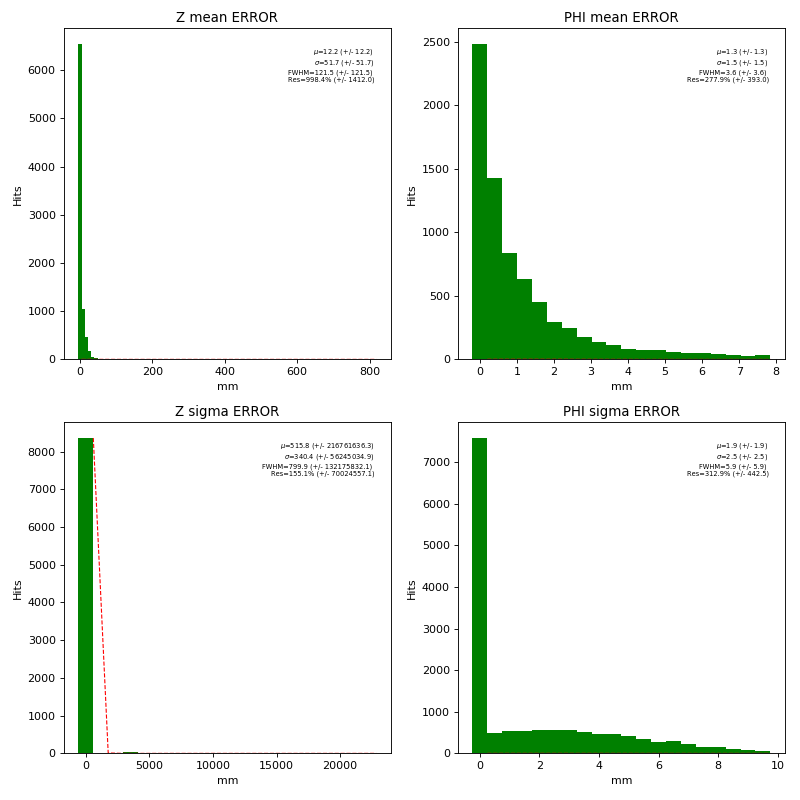

Fitting Problems
Fitting Problems
Fitting Problems


In [10]:
err_fit = fit.gauss_fit()
fig = plt.figure(figsize=(10,10))
err_fit(z_m_err,'sqrt')
err_fit.plot(axis = fig.add_subplot(221),
                title = "Z mean ERROR",
                xlabel = "mm",
                ylabel = "Hits",
                res = True, fit = True)
err_fit(phi_m_err,20)
err_fit.plot(axis = fig.add_subplot(222),
                title = "PHI mean ERROR",
                xlabel = "mm",
                ylabel = "Hits",
                res = True, fit = True)
err_fit(z_s_err,20)
err_fit.plot(axis = fig.add_subplot(223),
                title = "Z sigma ERROR",
                xlabel = "mm",
                ylabel = "Hits",
                res = True, fit = True)
err_fit(phi_s_err,20)
err_fit.plot(axis = fig.add_subplot(224),
                title = "PHI sigma ERROR",
                xlabel = "mm",
                ylabel = "Hits",
                res = True, fit = True)
fig.tight_layout()
plt.show()